### generate_synthetic_principles_for_agents.ipynb
This notebook generates an agents synthetic principles for use in HCVA and stores these in a `.csv` file
- Takes an individual agents value system
    - finds the decision they would take, and assigns the agent an ethical principle that fits with their view, or is the opposite of their view according to some probability $p$

In [109]:
import pandas as pd
import numpy as np

#####
# 08/01/2025: 1.0 = Utilitarian, 1.4 = Transition point, 10.0 = Egalitarian
###
relevent_consensuses = [round(x * 0.1, 1) for x in range(10, 101)]
relevant_columns = ['p','Rel-Nonrel', 'Nonrel-Rel', 'Rel_div_p', 'Nonrel_div_p', 'Egal-Util', 'Util-Egal']

actions_filename = "/home/ia23938/Documents/GitHub/ValueSystemsAggregation/data/ess_example_data/single_example_results/single_example/08-01-2025-actions.csv"
preference_filename = '/home/ia23938/Documents/GitHub/ValueSystemsAggregation/data/ess_example_data/single_example_results/single_example/08-01-2025-preferences.csv'

final_df_savename = "/home/ia23938/Documents/GitHub/ValueSystemsAggregation/data/ess_example_data/10-01-2025-ess-relevant-consensus.csv"

pref_df = pd.read_csv(preference_filename)
act_df = pd.read_csv(actions_filename)
cons_df = pd.merge(pref_df, act_df, on='p')
cons_df['p'] = cons_df['p'].round(1)

       p  Rel-Nonrel  Nonrel-Rel  Rel_div_p  Nonrel_div_p  Egal-Util  Util-Egal  decision
0    1.0    0.346411    0.653589   0.001517      0.028995   0.000000   1.000000  0.019476
1    1.1    0.346043    0.653957  -0.006315      0.028138   0.011111   0.988889  0.016216
2    1.2    0.345798    0.654202  -0.014573      0.022175   0.022222   0.977778  0.009468
3    1.3    0.345695    0.654305  -0.018456      0.018935   0.033333   0.966667  0.006009
4    1.4    0.345776    0.654224  -0.020717      0.017142   0.044444   0.955556  0.004051
5    1.5    0.346117    0.653883  -0.022280      0.016003   0.055556   0.944444  0.002753
6    1.6    0.346774    0.653226  -0.023652      0.015134   0.066667   0.933333  0.001684
7    1.7    0.347730    0.652270  -0.024931      0.014435   0.077778   0.922222  0.000746
8    1.8    0.349271    0.650729  -0.026228      0.013833   0.088889   0.911111 -0.000159
9    1.9    0.350279    0.649721  -0.026999      0.013505   0.100000   0.900000 -0.000682
10   2.0  

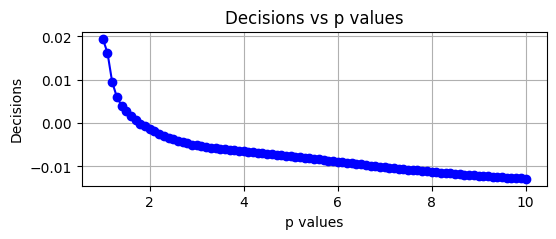

In [110]:
# for each row, find the corresponding Util-Egal and Egal-Util values (where P=1.0 has Util-Egal=1.0 and Egal-Util=0.0, and P=10.0 has Util-Egal=0.0 and Egal-Util=1.0)
for index, row in cons_df.iterrows():
    cons_df.at[index, 'Egal-Util'] = (row['p'] - 1) / 9
    cons_df.at[index, 'Util-Egal'] = 1 - cons_df.at[index, 'Egal-Util']
final_df = pd.DataFrame()
for consensus in relevent_consensuses:
    filtered_df = cons_df[cons_df['p'] == consensus][relevant_columns]
    filtered_df['decision'] = (filtered_df['Rel_div_p'] * filtered_df['Rel-Nonrel']) + (filtered_df['Nonrel_div_p'] * filtered_df['Nonrel-Rel'])
    final_df = pd.concat([final_df, filtered_df], ignore_index=True)
final_df.to_csv(final_df_savename)
print(final_df.to_string())

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 2))
plt.plot(final_df['p'], final_df['decision'], marker='o', linestyle='-', color='b')
plt.xlabel('p values')
plt.ylabel('Decisions')
plt.title('Decisions vs p values')
plt.grid(True)
plt.show()

In [111]:
# Split final_df into two dataframes based on the decision column
positive_df = final_df[final_df['decision'] > 0]
negative_df = final_df[final_df['decision'] < 0]

# Find quartile vals
postive_quartiles = positive_df['decision'].quantile([0.25, 0.5, 0.75])
negative_quartiles = negative_df['decision'].quantile([0.25, 0.5, 0.75])

positive_quartile_p_values = {
    'Q1': positive_df[positive_df['decision'] <= postive_quartiles[0.25]]['p'].tolist(),
    'Q2': positive_df[(positive_df['decision'] > postive_quartiles[0.25]) & (positive_df['decision'] <= postive_quartiles[0.5])]['p'].tolist(),
    'Q3': positive_df[(positive_df['decision'] > postive_quartiles[0.5]) & (positive_df['decision'] <= postive_quartiles[0.75])]['p'].tolist(),
    'Q4': positive_df[positive_df['decision'] > postive_quartiles[0.75]]['p'].tolist()
}

negative_quartile_p_values = {
    'Q1': negative_df[negative_df['decision'] <= negative_quartiles[0.25]]['p'].tolist(),
    'Q2': negative_df[(negative_df['decision'] > negative_quartiles[0.25]) & (negative_df['decision'] <= negative_quartiles[0.5])]['p'].tolist(),
    'Q3': negative_df[(negative_df['decision'] > negative_quartiles[0.5]) & (negative_df['decision'] <= negative_quartiles[0.75])]['p'].tolist(),
    'Q4': negative_df[negative_df['decision'] > negative_quartiles[0.75]]['p'].tolist()
}

print("Positive Quartile p values:", positive_quartile_p_values)
print("Negative Quartile p values:", negative_quartile_p_values)

Positive Quartile p values: {'Q1': [1.6, 1.7], 'Q2': [1.4, 1.5], 'Q3': [1.2, 1.3], 'Q4': [1.0, 1.1]}
Negative Quartile p values: {'Q1': [8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0], 'Q2': [5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9], 'Q3': [3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8], 'Q4': [1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8]}


In [112]:
# Read in data
agent_csv_file = "/home/ia23938/Documents/GitHub/ValueSystemsAggregation/data/ess_example_data/single_example_results/single_example/08-01-2025-agent-data.csv"
df = pd.read_csv(agent_csv_file)
for index, row in df.iterrows():
    df.at[index, 'decision'] = (row['Rel-Nonrel'] * row['a_div_rel']) + (row['Nonrel-Rel'] * row['a_div_nonrel'])
# sanity check
print(df.head())

  country   rel  nonrel  Rel-Nonrel  Nonrel-Rel  a_div_rel  a_div_nonrel  \
0      AT   642    1216    0.345533    0.654467   0.047767      0.112390   
1      BE   621    1116    0.357513    0.642487  -0.063875     -0.054361   
2      CH   767     666    0.535241    0.464759   0.150804      0.262262   
3      CZ   577    1483    0.280097    0.719903   0.021375      0.028995   
4      DE  1264    1488    0.459302    0.540698   0.002110      0.068100   

   decision  
0  0.090061  
1 -0.057762  
2  0.202605  
3  0.026861  
4  0.037791  


In [113]:
def binary_principles(df):
    df['decision'] = np.nan  # Initialize the 'decision' column

    for index, row in df.iterrows():
        df.at[index, 'decision'] = (row['rel-nonrel'] * row['a_div_rel']) + (row['nonrel-rel'] * row['a_div_nonrel'])
        if df.at[index, 'decision'] < 0:
            df.at[index, 'egal'] = 1
            df.at[index, 'util'] = 0
        else:
            df.at[index, 'egal'] = 0
            df.at[index, 'util'] = 1
    return df

def range_principles(df, against_scheme, for_scheme):
    """
    This function calculates the decision based on the range of principles
    - factor is calculated as a random p value the agent will hold. 
        The principle will be calculated from principles that are in support to the agents real choice
    """
    for index, row in df.iterrows():
        total_interviewees = row['rel'] + row['nonrel']

        if df.at[index, 'decision'] < 0:
            factor = np.random.choice(against_scheme)
            egal = (factor / 10) * total_interviewees
            util = total_interviewees - egal
            egal = round(egal, 0)
            util = round(util, 0)
            # Factor is 1.0 then [egal, util] = [0, 1]
            # Factor is 10.0 then [egal, util] = [1, 0]
            # Factor is 1.8 then [egal, util] = [0.18, 0.82]

            df.at[index, 'egal'] = egal
            df.at[index, 'util'] = util
        else:
            factor = np.random.choice(for_scheme)
            egal = (factor / 10) * total_interviewees
            util = total_interviewees - egal
            egal = round(egal, 0)
            util = round(util, 0)
            df.at[index, 'egal'] = egal
            df.at[index, 'util'] = util
    return df


In [114]:
"""## Make general supporting principles
against_scheme = list(np.arange(1.8, 10.0, 0.1))
for_scheme = list(np.arange(1.0, 1.7, 0.1))
against_scheme = [round(num, 1) for num in against_scheme]
for_scheme = [round(num, 1) for num in for_scheme]

df = range_principles(df, against_scheme, for_scheme)
print(df.head())
# Save the principles a file
principles_df = df[['country', 'egal', 'util']]
principles_df.rename(columns={'egal': 'rel', 'util': 'nonrel'}, inplace=True)

principles_df.to_csv("/home/ia23938/Documents/GitHub/ValueSystemsAggregation/data/ess_example_data/single_example_results/single_example/15-01-2025-principles-3.csv", index=False)
"""

'## Make general supporting principles\nagainst_scheme = list(np.arange(1.8, 10.0, 0.1))\nfor_scheme = list(np.arange(1.0, 1.7, 0.1))\nagainst_scheme = [round(num, 1) for num in against_scheme]\nfor_scheme = [round(num, 1) for num in for_scheme]\n\ndf = range_principles(df, against_scheme, for_scheme)\nprint(df.head())\n# Save the principles a file\nprinciples_df = df[[\'country\', \'egal\', \'util\']]\nprinciples_df.rename(columns={\'egal\': \'rel\', \'util\': \'nonrel\'}, inplace=True)\n\nprinciples_df.to_csv("/home/ia23938/Documents/GitHub/ValueSystemsAggregation/data/ess_example_data/single_example_results/single_example/15-01-2025-principles-3.csv", index=False)\n'

In [115]:
###################
# Make Test Cases #
###################
## Extreme Util (1): All agents are utilitarian
for_scheme = [value for sublist in positive_quartile_p_values.values() for value in sublist]
against_scheme = for_scheme
df = range_principles(df, against_scheme, for_scheme)
# Save the principles a file
principles_df = df[['country', 'egal', 'util']]
principles_df.rename(columns={'egal': 'rel', 'util': 'nonrel'}, inplace=True)
principles_df.to_csv("/home/ia23938/Documents/GitHub/ValueSystemsAggregation/data/ess_example_data/single_example_results/single_example/15-01-2025-extreme-util-principles.csv", index=False)

## Extreme 2: All agents are egalitarian
for_scheme = [value for sublist in negative_quartile_p_values.values() for value in sublist]
against_scheme = for_scheme
df = range_principles(df, against_scheme, for_scheme)
# Save the principles a file
principles_df = df[['country', 'egal', 'util']]
principles_df.rename(columns={'egal': 'rel', 'util': 'nonrel'}, inplace=True)
principles_df.to_csv("/home/ia23938/Documents/GitHub/ValueSystemsAggregation/data/ess_example_data/single_example_results/single_example/15-01-2025-extreme-egal-principles.csv", index=False)

# Random 1: Randomly assign agents to be utilitarian or egalitarian by any extent 
for_scheme = list(np.arange(1.0, 10.0, 0.1))
for_scheme = [round(num, 1) for num in for_scheme]
against_scheme = for_scheme
df = range_principles(df, against_scheme, for_scheme)
# Save the principles a file
principles_df = df[['country', 'egal', 'util']]
principles_df.rename(columns={'egal': 'rel', 'util': 'nonrel'}, inplace=True)
principles_df.to_csv("/home/ia23938/Documents/GitHub/ValueSystemsAggregation/data/ess_example_data/single_example_results/single_example/15-01-2025-random-principles.csv", index=False)

# Quartile 1: Assign agents to be in top quartile utilitarian or egalitarian based on their decision (high investment)
for_scheme = positive_quartile_p_values['Q4']
against_scheme = negative_quartile_p_values['Q1']
print(for_scheme)
print(against_scheme)
df = range_principles(df, against_scheme, for_scheme)
# Save the principles a file
principles_df = df[['country', 'egal', 'util']]
principles_df.rename(columns={'egal': 'rel', 'util': 'nonrel'}, inplace=True)
principles_df.to_csv("/home/ia23938/Documents/GitHub/ValueSystemsAggregation/data/ess_example_data/single_example_results/single_example/15-01-2025-top-quartile-principles.csv", index=False)

# Quartile 2: Assign agents to be in bottom quartile utilitarian or egalitarian based on their decision (low investment)
for_scheme = positive_quartile_p_values['Q1']
against_scheme = negative_quartile_p_values['Q4']
print(for_scheme)
print(against_scheme)
df = range_principles(df, against_scheme, for_scheme)
# Save the principles a file
principles_df = df[['country', 'egal', 'util']]
principles_df.rename(columns={'egal': 'rel', 'util': 'nonrel'}, inplace=True)
principles_df.to_csv("/home/ia23938/Documents/GitHub/ValueSystemsAggregation/data/ess_example_data/single_example_results/single_example/15-01-2025-bottom-quartile-principles.csv", index=False)

[1.0, 1.1]
[8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0]
[1.6, 1.7]
[1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8]


/tmp/ipykernel_227619/2474337772.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  principles_df.rename(columns={'egal': 'rel', 'util': 'nonrel'}, inplace=True)
/tmp/ipykernel_227619/2474337772.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  principles_df.rename(columns={'egal': 'rel', 'util': 'nonrel'}, inplace=True)
/tmp/ipykernel_227619/2474337772.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  principles_df.rename(colu

In [117]:
## General support and general opposition principles using quartiles
for_scheme = positive_quartile_p_values['Q4'] + positive_quartile_p_values['Q3'] + positive_quartile_p_values['Q2']
against_scheme = negative_quartile_p_values['Q1'] + negative_quartile_p_values['Q2'] + negative_quartile_p_values['Q3']
print(for_scheme)
print(against_scheme)
df = range_principles(df, against_scheme, for_scheme)
# Save the principles a file
principles_df = df[['country', 'egal', 'util']]
principles_df.rename(columns={'egal': 'rel', 'util': 'nonrel'}, inplace=True)
principles_df.to_csv("/home/ia23938/Documents/GitHub/ValueSystemsAggregation/data/ess_example_data/single_example_results/single_example/15-01-2025-general-support-principles.csv", index=False)

[1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
[8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8]


/tmp/ipykernel_227619/4122970553.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  principles_df.rename(columns={'egal': 'rel', 'util': 'nonrel'}, inplace=True)


In [118]:
## General support and general opposition principles using quartiles
against_scheme = positive_quartile_p_values['Q4'] + positive_quartile_p_values['Q3'] + positive_quartile_p_values['Q2']
for_scheme = negative_quartile_p_values['Q1'] + negative_quartile_p_values['Q2'] + negative_quartile_p_values['Q3']

print(for_scheme)
print(against_scheme)
df = range_principles(df, against_scheme, for_scheme)
# Save the principles a file
principles_df = df[['country', 'egal', 'util']]
principles_df.rename(columns={'egal': 'rel', 'util': 'nonrel'}, inplace=True)
principles_df.to_csv("/home/ia23938/Documents/GitHub/ValueSystemsAggregation/data/ess_example_data/single_example_results/single_example/15-01-2025-general-opposition-principles.csv", index=False)

[8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8]
[1.0, 1.1, 1.2, 1.3, 1.4, 1.5]


/tmp/ipykernel_227619/3696312703.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  principles_df.rename(columns={'egal': 'rel', 'util': 'nonrel'}, inplace=True)


In [119]:
## General support and general opposition principles using quartiles
for_scheme = positive_quartile_p_values['Q4'] + positive_quartile_p_values['Q3']
against_scheme = negative_quartile_p_values['Q1'] + negative_quartile_p_values['Q2']
print(for_scheme)
print(against_scheme)
df = range_principles(df, against_scheme, for_scheme)
# Save the principles a file
principles_df = df[['country', 'egal', 'util']]
principles_df.rename(columns={'egal': 'rel', 'util': 'nonrel'}, inplace=True)
principles_df.to_csv("/home/ia23938/Documents/GitHub/ValueSystemsAggregation/data/ess_example_data/single_example_results/single_example/15-01-2025-50-pc-support-principles.csv", index=False)

## General support and general opposition principles using quartiles
against_scheme = positive_quartile_p_values['Q4'] + positive_quartile_p_values['Q3']
for_scheme = negative_quartile_p_values['Q1'] + negative_quartile_p_values['Q2']

print(for_scheme)
print(against_scheme)
df = range_principles(df, against_scheme, for_scheme)
# Save the principles a file
principles_df = df[['country', 'egal', 'util']]
principles_df.rename(columns={'egal': 'rel', 'util': 'nonrel'}, inplace=True)
principles_df.to_csv("/home/ia23938/Documents/GitHub/ValueSystemsAggregation/data/ess_example_data/single_example_results/single_example/15-01-2025-50-pc-opposition-principles.csv", index=False)

[1.0, 1.1, 1.2, 1.3]
[8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9]
[8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9]
[1.0, 1.1, 1.2, 1.3]


/tmp/ipykernel_227619/3304912680.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  principles_df.rename(columns={'egal': 'rel', 'util': 'nonrel'}, inplace=True)
/tmp/ipykernel_227619/3304912680.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  principles_df.rename(columns={'egal': 'rel', 'util': 'nonrel'}, inplace=True)
